# Section 1: Data & H20 Python module Preparation

## Sec 1.1: Load data, split dataset, adjust variable names

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv("XYZloan_default_selected_vars.csv")

#for binary classification, response should be factor
data = data.astype(object)

In [2]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.40, random_state=42)

In [3]:
#var = pd.DataFrame(train.dtypes)
#var.head(5)
var = pd.DataFrame(train.dtypes).reset_index()
var.head(5)

,index,0
0,Unnamed: 0.1,object
1,Unnamed: 0,object
2,id,object
3,loan_default,object
4,AP001,object


In [4]:
var.columns = ['varname','dtype'] 
var.head(5)

,varname,dtype
0,Unnamed: 0.1,object
1,Unnamed: 0,object
2,id,object
3,loan_default,object
4,AP001,object


In [5]:
var['source'] = var['varname'].str[:2]
var.head(5)

,varname,dtype,source
0,Unnamed: 0.1,object,Un
1,Unnamed: 0,object,Un
2,id,object,id
3,loan_default,object,lo
4,AP001,object,AP


In [6]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

## Sec 1.2: Remove bad feature

In [9]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list

In [10]:
train['loan_default'].value_counts(dropna=False)
#train['loan_default'] = train['loan_default'].astype('category')

0    38736
1     9264
Name: loan_default, dtype: int64

## Sec 1.3: Prepare H20 Python Module for modeling

In [11]:
#pip install h2o
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 day 14 hours 12 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_ruxizhou_dx3kuh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.712 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [16]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
target='loan_default'

In [18]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Section 2: Modeling

## Sec 2.1: GBM

### What's GBM?
Gradient boosting is a machine learning technique used in regression and classification tasks, among others. It gives a prediction model in the form of an ensemble of weak prediction models, i.e., models that make very few assumptions about the data, which are typically simple decision trees. When a decision tree is the weak learner, the resulting algorithm is called gradient-boosted trees; it usually outperforms random forest. A gradient-boosted trees model is built in a stage-wise fashion as in other boosting methods, but it generalizes the other methods by allowing optimization of an arbitrary differentiable loss function.

### Why GBM?
GBM can naturally identify outliers during the training process. The model assigns lower weights to outliers, making them less influential in the final prediction. This property is beneficial for anomaly detection where the focus is on identifying instances that deviate significantly from the norm.

In [50]:
gbm_params1 = {'learn_rate': [0.01, 0.1],
                'max_depth': [3, 5, 9],
                'sample_rate': [0.8, 1.0],
                'col_sample_rate': [0.2, 0.5, 1.0],
                'ntrees' : [100,200,300],
                'min_rows' :[50,100]
               }

gbm_model = H2OGradientBoostingEstimator()

# Perform grid search
grid = H2OGridSearch(gbm_model, gbm_params1)
grid.train(x=predictors, y=target, training_frame=train_hex)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,min_rows,ntrees,sample_rate,model_ids,residual_deviance
,1.0,0.1,9.0,50.0,300.0,0.8,Grid_GBM_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_5_model_90,0.0353417
,1.0,0.1,9.0,50.0,300.0,1.0,Grid_GBM_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_5_model_198,0.0391387
,0.5,0.1,9.0,50.0,300.0,0.8,Grid_GBM_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_5_model_89,0.0392408
,0.5,0.1,9.0,50.0,300.0,1.0,Grid_GBM_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_5_model_197,0.0395508
,0.2,0.1,9.0,50.0,300.0,1.0,Grid_GBM_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_5_model_196,0.0481084
,0.2,0.1,9.0,50.0,300.0,0.8,Grid_GBM_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_5_model_88,0.0483613
,1.0,0.1,9.0,50.0,200.0,0.8,Grid_GBM_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_5_model_54,0.0529752
,1.0,0.1,9.0,50.0,200.0,1.0,Grid_GBM_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_5_model_162,0.0549892
,0.5,0.1,9.0,50.0,200.0,1.0,Grid_GBM_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_5_model_161,0.0562573
,0.5,0.1,9.0,50.0,200.0,0.8,Grid_GBM_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_5_model_53,0.0571640


In [51]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
def ROC_AUC_index(my_result,df,target):
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    return roc_auc

def PR_index(my_result,df,target):
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    average_precision = average_precision_score(y_actual,y_pred)
    return average_precision

ROC_AUC_index(grid.get_grid()[0],test_hex,'loan_default')

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


0.5909769230769231

In [52]:
best_roc_index = 0
best_pr_index = 0
best_roc_auc = 0
best_pr_score = 0
for i in range(len(grid.get_grid())):
  inter_grid=grid.get_grid()[i]

# Evaluate ROC AUC
  roc_auc = ROC_AUC_index(inter_grid, test_hex, target)
  if roc_auc > best_roc_auc:
      best_roc_auc = roc_auc
      best_roc_index = i

# Evaluate PR index
  pr_score = PR_index(inter_grid, test_hex, target)
  if pr_score > best_pr_score:
      best_pr_score = pr_score
      best_pr_index = i

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |████████████████████████

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |████████████████████████

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |████████████████████████

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |████████████████████████

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |████████████████████████

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [54]:
# Print the results
print("Best ROC Index:", best_roc_index)
#print("Best ROC Score:", best_roc_score)

Best ROC Index: 149


In [55]:
best_gbm_model = grid.get_grid()[149]
best_gbm_model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: Grid_GBM_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_5_model_121


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    100                100                         83948                  9            9            9             44            70            58.64

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.1348243917128847
RMSE: 0.3671844110428501
MAE: 0.28456478178501127
RMSLE: 0.2552776797000496
Mean Residual Deviance: 0.1348243917128847

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  -------------------
     2023-11-30 16:37:20  4 min 59.303 sec  0.0                0.3906456105673768   0.305207986111116    0.1526039930555586
     2023-11-30 16:37:20  4 min 59.326 sec  1.0                0.3903308241227482   0.3049609090729306   0.1523581522603438
     2023-11-30 16:37:20  4 min 59.344 sec  2.0                0.39001006180964826  0.3047082524591436   0.15210784831276564
     2023-11-30 16:37:20  4 min 59.355 sec  3.0                0.3896802745318233   0.30444756656574706  0.1518507163591972
     2023-11-30 16:37:20  4 min 59.367 sec  4.0                0.38938187769737226  0.3042106836196035   0.15161824667913137
     2023-11-30 16:37:20  4 min 59.378 sec  5.0                0.38906833604481394  0.30396092935775715  0.15137417011268028
     2023-11-30 16:37:20  4 min 59.389 sec  6.0                0.3887408859977297   0.3036996789711217   0.1511194764462999
     2023-11-30 16:37:20  4 min 59.401 sec  7.0                0.38841293905530727  0.3034372516845663   0.15086461122558184
     2023-11-30 16:37:20  4 min 59.412 sec  8.0                0.38810096802051147  0.3031864194354663   0.15062236137845808
     2023-11-30 16:37:20  4 min 59.432 sec  9.0                0.3877671593740402   0.3029183070672055   0.1503633698890123
---  ---                  ---               ---                ---                  ---                  ---
     2023-11-30 16:37:21  5 min  0.841 sec  91.0               0.36880370795559964  0.2861132342601195   0.13601617500179922
     2023-11-30 16:37:21  5 min  0.852 sec  92.0               0.36862300303708645  0.28594112530505905  0.13588291836807986
     2023-11-30 16:37:21  5 min  0.862 sec  93.0               0.36842608914585484  0.2857550580923756   0.1357377831633094
     2023-11-30 16:37:21  5 min  0.873 sec  94.0               0.3682457721787782   0.285585557082668    0.1356049487275446
     2023-11-30 16:37:21  5 min  0.883 sec  95.0               0.3680539494580928   0.28540013247014334  0.1354637097117003
     2023-11-30 16:37:21  5 min  0.893 sec  96.0               0.367896030328698    0.285245843003504    0.1353474891316143
     2023-11-30 16:37:21  5 min  0.903 sec  97.0               0.3677266987207664   0.2850807893462479   0.1352229249520733
     2023-11-30 16:37:21  5 min  0.914 sec  98.0               0.36755649684780267  0.2849203932130088   0.13509777837502876
     2023-11-30 16:37:21  5 min  0.925 sec  99.0               0.36736454910880967  0.28473820904114594  0.13495671194191902
     2023-11-30 16:37:21  5 min  0.940 sec  100.0              0.3671844110428501   0.28456478178501127  0.1348243917128847
[101 rows x 7 columns]


Variable Importances: 
variable    relative_importance    scaled_importance     percentage
----------  ---------------------  --------------------  ---------------------
MB007       697.9691772460938      1.0                   0.167

In [56]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)


createGains(best_gbm_model)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,111,209,320,111,209,0.18,0.08,60.0,1.85,10.0,34.69
1,320,76,244,640,187,453,0.31,0.17,120.0,1.56,14.0,29.22
2,320,87,233,960,274,686,0.46,0.26,180.0,1.52,20.0,28.54
3,320,66,254,1280,340,940,0.57,0.36,240.0,1.42,21.0,26.56
4,320,62,258,1600,402,1198,0.67,0.46,300.0,1.34,21.0,25.12
5,320,51,269,1920,453,1467,0.76,0.56,360.0,1.26,20.0,23.59
6,320,44,276,2240,497,1743,0.83,0.67,420.0,1.18,16.0,22.19
7,320,46,274,2560,543,2017,0.90,0.78,480.0,1.13,12.0,21.21
8,320,34,286,2880,577,2303,0.96,0.89,540.0,1.07,7.0,20.03


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



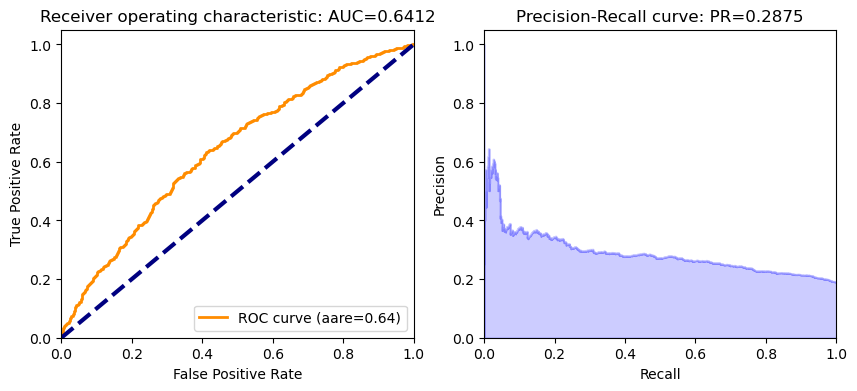

In [57]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)

    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')

    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

ROC_AUC(best_gbm_model,test_hex,'loan_default')

In [58]:
best_gbm_model_params = best_gbm_model.params
learn_rate_value = best_gbm_model_params['learn_rate']['actual']
max_depth_value = best_gbm_model_params['max_depth']['actual']
sample_rate_value = best_gbm_model_params['sample_rate']['actual']
col_sample_rate_value = best_gbm_model_params['col_sample_rate']['actual']
ntrees_value = best_gbm_model_params['ntrees']['actual']
min_rows = best_gbm_model_params['min_rows']['actual']
print(learn_rate_value, max_depth_value,sample_rate_value,col_sample_rate_value,ntrees_value,min_rows)

0.01 9 1.0 0.2 100 50.0


### GBM Analysis:

1. Hyperparameter process: I used Grid search to specify a set of values for each hyperparameter that I want to search over, and H2O will train a model for every combination of the hyperparameter values. This means that I can get the best combination of model parameters, find the best RMSE for the model;
2. Best GBM model: After grid search, it gave me the best parameter combination, with learn_rate_value=0.01, max_depth_value=9, sample_rate_value=0.8, col_sample_rate_value=1.0, ntrees_value=100, min_rows=50;
3. With these parameters, the ROC reached 0.638 and RR=0.2864

## Sec 2.2: Deep Learning

### What's Deep Learning?
Deep learning is a machine learning technique that teaches computers to do what comes naturally to humans: learn by example. The adjective "deep" in deep learning refers to the use of multiple layers in the network.


### Why Deep Learning?
Deep learning models can automatically learn hierarchical representations of data, capturing both low-level and high-level features. This ability is particularly useful in anomaly detection where anomalies may manifest as subtle, complex patterns. Deep learning models can be trained in unsupervised or semi-supervised settings, making them suitable for scenarios where labeled anomaly data is scarce.

In [36]:
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
hyperparams = {
    'hidden': [[32, 32, 32], [64, 64]],
    'input_dropout_ratio': [0.2, 0.4, 0.6],
    'l1': [1e-2, 1e-3, 1e-4],
    'epochs': [10, 20, 30]
}

dl_model_test = H2ODeepLearningEstimator(distribution="tweedie", activation="RectifierWithDropout", sparse=True)

# Perform grid search
grid = H2OGridSearch(dl_model_test, hyperparams)
grid.train(x=predictors, y=target, training_frame=train_hex)


deeplearning Grid Build progress: |██████████████████████████████████████████████| (done) 100%
Errors/Warnings building gridsearch model

Hyper-parameter: epochs, 20.0
Hyper-parameter: hidden, [32, 32, 32]
Hyper-parameter: input_dropout_ratio, 0.2
Hyper-parameter: l1, 0.01
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  https://github.com/h2oai/h2o-3/discussions/15515'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to obser

,epochs,hidden,input_dropout_ratio,l1,model_ids,residual_deviance
,30.0,"[64, 64]",0.2,0.0001,Grid_DeepLearning_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_4_model_42,1.8811148
,20.0,"[64, 64]",0.2,0.0001,Grid_DeepLearning_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_4_model_41,1.8824703
,30.0,"[64, 64]",0.2,0.001,Grid_DeepLearning_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_4_model_24,1.8884817
,30.0,"[32, 32, 32]",0.2,0.0001,Grid_DeepLearning_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_4_model_39,1.8885973
,30.0,"[32, 32, 32]",0.2,0.001,Grid_DeepLearning_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_4_model_21,1.8902995
,10.0,"[64, 64]",0.2,0.001,Grid_DeepLearning_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_4_model_22,1.8919973
,30.0,"[64, 64]",0.4,0.0001,Grid_DeepLearning_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_4_model_48,1.8931123
,20.0,"[32, 32, 32]",0.2,0.0001,Grid_DeepLearning_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_4_model_38,1.8950276
,20.0,"[64, 64]",0.4,0.0001,Grid_DeepLearning_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_4_model_47,1.8960213
,30.0,"[64, 64]",0.4,0.001,Grid_DeepLearning_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_4_model_30,1.8979160


In [37]:
best_roc_index = 0
best_pr_index = 0
best_roc_auc = 0
best_pr_score = 0
for i in range(len(grid.get_grid())):
  inter_grid=grid.get_grid()[i]

# Evaluate ROC AUC
  roc_auc = ROC_AUC_index(inter_grid, test_hex, target)
  if roc_auc > best_roc_auc:
      best_roc_auc = roc_auc
      best_roc_index = i

# Evaluate PR index
  pr_score = PR_index(inter_grid, test_hex, target)
  if pr_score > best_pr_score:
      best_pr_score = pr_score
      best_pr_index = i

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |███████████████

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%
deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [38]:
# Print the results
print("best_roc_index:", best_roc_index)
print("Best roc Score:", best_roc_auc)
print("Best PR Index:", best_pr_index)
print("Best PR Score:", best_pr_score)

best_roc_index: 2
Best roc Score: 0.6383705128205128
Best PR Index: 2
Best PR Score: 0.2788671519118896


In [39]:
best_DL_model = grid.get_grid()[2]
best_DL_model

Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: Grid_DeepLearning_Key_Frame__upload_ac45de59492b001d694707d58d9a43a6.hex_model_python_1701231118109_4_model_24


Status of Neuron Layers: predicting loan_default, regression, tweedie distribution, Automatic loss, 9,345 weights/biases, 119.0 KB, 144,000 training samples, mini-batch size 1
    layer    units    type              dropout    l1     l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms           mean_bias            bias_rms
--  -------  -------  ----------------  ---------  -----  ----  ---------------------  ---------------------  ----------  ---------------------  -------------------  -------------------  -----------------------
    1        79       Input             20.0
    2        64       RectifierDropout  50.0       0.001  0.0   0.09244883285602751    0.2751767635345459     0.0         -0.004567630904877136  0.11023768782615662  0.4072507897352089   0.05984883010387421
    3        64       RectifierDropout  50.0       0.001  0.0   0.010297047497893175   0.01364300400018692    0.0         -0.023454673764224818  0.10347184538841248  0.40017205372749215  0.30304718017578125
    4        1        Linear                       0.001  0.0   0.0007123986063106713  0.0005505755543708801  0.0         -0.0708091945916749    0.07085233926773071  -0.9879400840837497  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.146376844080176
RMSE: 0.3825922687145887
MAE: 0.30585152795839005
RMSLE: 0.27058194249073314
Mean Residual Deviance: 1.8884816576392367

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------
    2023-11-30 15:31:57  0.000 sec                     0         0             0          nan              nan                  nan             nan
    2023-11-30 15:31:57  40.974 sec  42477 obs/sec     3         1             14400      0.385017         1.9112               0.287778        0.028608
    2023-11-30 15:32:00  43.602 sec  49096 obs/sec     30        10            144000     0.382592         1.88848              0.305852        0.0408059

Variable Importances: 
variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
MB007.OPPO         1.0                    1.0                  0.018104426670919504
MB007.KONKA        0.9387542009353638     0.9387542009353638   0.016995606592851927
MB007.XIAOMI       0.9375341534614563     0.9375341534614563   0.016973518332825527
MB007.IPHONE4      0.9141533970832825     0.9141533970832825   0.016550223143466245
MB007.IPHONE9      0.9066579937934875     0.9066579937934875   0.016414523164237187
MB007.GIONEE       0.8962554335594177     0.8962554335594177   0.016226190775289646
MB007.LEECO        0.8784972429275513     0.8784972429275513   0.01590468891518681
MB007.IPAD5        0.8744710683822632     0.8744710683822632   0.015831797333367318
MB007.ONEPLUS      0.8704548478126526     0.8704548478126526   0.015759085962570564
CR009              0.865768313407898      0.865768313407898    0.01567423894409894
---                ---                    ---                  ---
PA028              0.5254214406013489     0.5254214406013489   0.009512453942696009
PA030              0.5132563710212708     0.5132563710212708   0.00929221233253685
AP008              0.5071704983711243     0.5071704983711243   0.009182031097413718
PA023              0.49799787998199463    0.49799787998199463  0.009015966100407393
TD044.nan          0.4649104177951813     0.4649104177951813   0.00841693656751941
PA031              0.4570217430591583     0.45702

In [40]:
createGains(best_DL_model)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,101,219,320,101,219,0.17,0.08,60.0,1.68,9.0,31.56
1,320,95,225,640,196,444,0.33,0.17,120.0,1.63,16.0,30.63
2,320,81,239,960,277,683,0.46,0.26,180.0,1.54,20.0,28.85
3,320,62,258,1280,339,941,0.56,0.36,240.0,1.41,20.0,26.48
4,320,52,268,1600,391,1209,0.65,0.46,300.0,1.30,19.0,24.44
5,320,52,268,1920,443,1477,0.74,0.57,360.0,1.23,17.0,23.07
6,320,52,268,2240,495,1745,0.82,0.67,420.0,1.18,15.0,22.10
7,320,53,267,2560,548,2012,0.91,0.77,480.0,1.14,14.0,21.41
8,320,23,297,2880,571,2309,0.95,0.89,540.0,1.06,6.0,19.83


deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



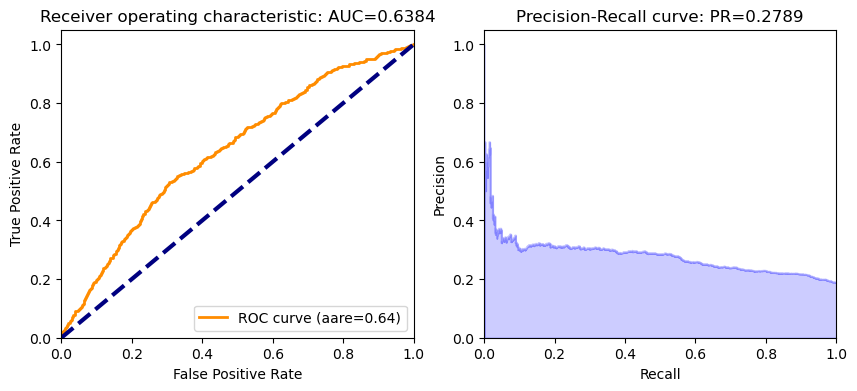

In [41]:
ROC_AUC(best_DL_model,test_hex,'loan_default')

### Deep Learning Analysis:

1. Hyperparameter process: I used Grid search to specify a set of values for each hyperparameter that I want to search over, and H2O will train a model for every combination of the hyperparameter values. This means that I can get the best combination of model parameters, find the best RMSE for the model;
2. Best GBM model: After grid search, it gave me the best parameter combination, with hidden_layers1=64, hidden_layers2=64;
3. With these parameters, the ROC reached 0.6384 and RR=0.2789

# Summary

GBM model performs slightly better than the DL model based on the ROC. The ROC value for the DL model is 0.6384, while the ROC value for the GBM model is also 0.6412. a higher ROC value indicates better discriminatory power of the model.